In [1]:
import tensorflow as tf

# Tensorflow操作

## 张量和操作

In [4]:
t = tf.constant([[1, 2, 3], 
                 [4, 5, 6]])  # 2*3矩阵，类似numpy

In [5]:
tf.constant(42) # 标量

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [8]:
t[:, 1:] # 索引类似numpy，先行后列

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [5, 6]])>

In [15]:
t[..., 1] # "..." 表示前（后）全部维度，即替换若干冒号

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 5])>

In [18]:
t[..., 1, tf.newaxis] # tf.newaxis增加新维度，放在右侧为增加一个列维度，放在左边增加一个行维度

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [5]])>

In [19]:
t

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [20]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[11, 12, 13],
       [14, 15, 16]])>

In [21]:
tf.square(t) # 平方

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  4,  9],
       [16, 25, 36]])>

In [23]:
tf.transpose(t) # 转置

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]])>

In [24]:
t @ tf.transpose(t) # 矩阵乘法

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]])>

In [27]:
tf.matmul(t, tf.transpose(t)) # 矩阵乘法

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]])>

In [25]:
tf.reduce_max(t)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [26]:
tf.reduce_sum(t)

<tf.Tensor: shape=(), dtype=int32, numpy=21>

## 张量与Numpy配合

In [30]:
import numpy as np

In [31]:
a = np.array([2, 4, 5])

In [32]:
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 4, 5])>

In [33]:
t.numpy()

array([[1, 2, 3],
       [4, 5, 6]])

In [34]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  4,  9],
       [16, 25, 36]])>

In [36]:
np.square(t)

array([[ 1,  4,  9],
       [16, 25, 36]], dtype=int32)

## 类型转换

必须要注意数据类型，比如浮点张量不能和整数张量相加，不能相加32位浮点张量和64位浮点张量。

tensorflow默认使用32位精度，Numpy默认64位

In [43]:
tf.constant(2.) + tf.constant(40) # 报错

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]

In [44]:
t2 = tf.constant(40, dtype=tf.float64)

In [45]:
tf.constant(2.0) + tf.cast(t2, tf.float32) # tf.cast() 转换类型

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## 变量

tf.Tensor 自身值是不变的，tf.Variable则可以变化

In [46]:
v = tf.Variable([[1., 2., 3.],[4., 5., 6.]])

In [47]:
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [50]:
v.assign(2 * v) # 分配值

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 4.,  8., 12.],
       [16., 20., 24.]], dtype=float32)>

In [52]:
v[0, 1].assign(42) # 指定位置重新分配值

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 4., 42., 12.],
       [16., 20., 24.]], dtype=float32)>

In [57]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.]) # 指定位置和更新值

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,  12.],
       [ 16.,  20., 200.]], dtype=float32)>

## 其他数据结构

书337

# 定制模型和训练算法

## 自定义损失函数

Huber损失——平滑平均绝对误差，替代MSE

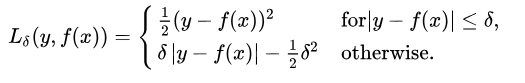

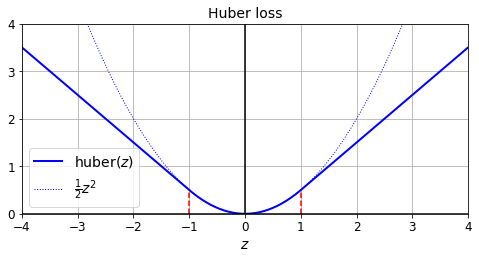

In [1]:
from tensorflow import keras

In [2]:
# 提取数据
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [76]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [19]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [77]:
model.compile(loss=create_huber(2), optimizer='nadam')  # 指定自定义的损失函数 create_huber()

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 846us/step - loss: 0.7910 - val_loss: 0.4718
Epoch 2/2
363/363 [==============================] - 0s 657us/step - loss: 0.2530 - val_loss: 0.3770


## 保存加载包含自定义组件的模型

In [82]:
model.save(r"model\my_model_with_a_custom_loss_threshold_2.h5")
# 直接保存不会保存损失函数的阈值
model = keras.models.load_model(r"model\my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [12]:
# 通过创建keras.losses.Loss类的子类，然后实现get_config()方法来保存参数
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config() # 继承keras.losses.Loss的get_config()方法来保存参数
        return {**base_config, 'threshold': self.threshold}

In [15]:
model.compile(loss=HuberLoss(2.), optimizer='nadam')

In [93]:
model.save(r"model\my_model_with_a_custom_loss_threshold_2.h5")
# 保存模型时，keras调用损失实例的get_config()方法，并将配置JSON格式保存到HDF5文件中，加载模型时将参数传递给函数

In [14]:
model = keras.models.load_model(r"model\my_model_with_a_custom_loss_threshold_2.h5",
                               custom_objects={'HuberLoss': HuberLoss})
# 无需再指定阈值

## 自定义激活函数、初始化、正则化和约束

In [1]:
import tensorflow as tf
from tensorflow import keras

In [6]:
def my_softplus(z): # 相当于tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):  # 相当于glorot_initializer(shape)
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weight))

def my_positive_weights(weights): # 相当于tf.nn.relu(weights)，约束权重大于0
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [7]:
layer = keras.layers.Dense(30, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)

In [10]:
# 保存正则化参数的l1正则化的简单类
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):  # 不用调用父类构造函数
        return {'factor': self.factor}

> 必须为损失、层（包括激活函数）和模型实现call()方法，或者为正则化、初始化和约束实现__call__()方法，对于指标则情况不同。

##  自定义指标

损失（如交叉熵）被梯度下降用来训练模型，因此他们必须是可微的（至少在求值的地方），并且梯度在任何地方都不应为0，另外损失如果不容易被人类理解也没有问题。

相反，指标（如准确率）用于评估模型，他们必须更容易被解释，并且可以是不可微的或在各处具有0梯度。

大多数情况下，定义一个自定义指标函数与定义一个自定义损失函数完全相同，实际上，我们甚至可以将之前创建的Huber损失函数用作指标（但是建议用MSE或MAE）。

In [20]:
model.compile(loss='mse', optimizer='nadam', metrics=[create_huber(2.0)])

In [21]:
# keras.metrics.Precision类可以跟踪真正的数量和假正的数量
precision = keras.metrics.Precision()

In [22]:
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [24]:
# 可以调用result()方法来获取指标的当前值，可以使用variables属性查看其变量，并且可以使用reset_states()方法重置这些变量
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [25]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>]

In [27]:
precision.reset_states() # 变量重新设为0

In [29]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [31]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 处理接收基本参数 (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros") # 用于跟踪所有Huber损失的总和
        self.count = self.add_weight("count", initializer="zeros") # 用于跟踪目前的实例数
    def update_state(self, y_true, y_pred, sample_weight=None): # 用于更新变量
        metric = self.huber_fn(y_true, y_pred) # 更新度量指标
        self.total.assign_add(tf.reduce_sum(metric)) # 更新损失的总和
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32)) # 更新实例数，tf.cast()于转换数据类型
    def result(self):
        return self.total / self.count # 计算返回最终结果
    def get_config(self): # 确保threshold与模型一起被保存
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

## 自定义层

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

### 单输入、单输出

In [3]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units # 神经元个数
        self.activation = keras.activation.get(activation) # 传入激活函数名称，'relu'等
    def build(self, batch_input_shape):
        self.kernel = self.add_weight( # 创建层的变量
            name='kernel', shape=[batch_input_shape[-1], self.units],
            initializer='glorot_normal')
        self.bias = self.add_weight( # 创建偏置项
            name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape) # 最后调用父类built()，执行创建层命令（必要）
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias) 
        # call()方法执行所需的操作，此时计算X与层内核的矩阵乘积并加上偏置项，对结果应用激活函数，获得层的输出
    def compute_output_shape(self, batch_input_shape): 
        # 返回该层输出的形状，最后一个维度背替换为该层神经元数量，有时可以省略
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units':self.units, # 保存其他参数（**base_config）加上两个自定义需要的参数
                'activation':keras.activations.serialize(self.activation)}

### 多输入、多输出

Concatenate层一般是多输入或输出，因此在call()和compute_output_shape()应该有对应数量的输入、输出

In [4]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return [X1 + X2, X1 * X2, X1 / X2] # 三个输出
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1] # 三个输出形状

### 测试和训练期间行为不同的层

创建一个训练期间添加高斯噪声（正则化）但在测试期间不执行任何操作的层

> keras.layers.GaussianNoise 功能相同

In [5]:
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    def call(self, X, training=None): # training=None 不训练时不加入噪音
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

## 自定义模型

加利福尼亚房价回归任务

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [7]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [8]:
X_new_scaled = X_test_scaled

该模型没有什么意义，只是作为示例

![image-2.png](attachment:image-2.png)

In [9]:
# 先建立一个残差层
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation='elu',
                                         kernel_initializer='he_normal') for _ in range(n_layers)]
        # 建立含有n_layers个密集层的隐藏层
        def call(self, inputs):
            Z = inputs
            for layer in self.hidden: # input在隐藏层循环一轮再输出
                Z = layer(Z)
            return inputs + Z # 返回原始输入值加上其通过隐藏层后的输出

In [10]:
# 建立模型
class ResidualRegressor(keras.Model): # 继承Model类
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation='elu', kernel_initializer='he_normal')
        self.block1 = ResidualBlock(2, 30) # 第一个残差层，包括2个隐藏层，每层30个神经元
        self.block2 = ResidualBlock(2, 30) # 第二个残差层
        self.out = keras.layers.Dense(output_dim)
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

若要实现保存参数，则在ResidualBlock类和ResidualRegressor类中都实现get_config()方法

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")

In [12]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 517us/step - loss: 1.8269
Epoch 2/5
363/363 [==============================] - 0s 518us/step - loss: 0.8722
Epoch 3/5
363/363 [==============================] - 0s 530us/step - loss: 0.6647
Epoch 4/5
363/363 [==============================] - 0s 519us/step - loss: 0.5604
Epoch 5/5
363/363 [==============================] - 0s 507us/step - loss: 0.4961


In [13]:
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

162/162 [==============================] - 0s 434us/step - loss: 0.4268


In [14]:
model.summary()

Model: "residual_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  270       
                                                                 
 residual_block (ResidualBlo  multiple                 0         
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  multiple                 0         
 lock)                                                           
                                                                 
 dense_5 (Dense)             multiple                  31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


也可以用顺序API构建

In [15]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([ # 顺序API构建
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 0s 511us/step - loss: 1.9205
Epoch 2/5
363/363 [==============================] - 0s 515us/step - loss: 0.5843
Epoch 3/5
363/363 [==============================] - 0s 515us/step - loss: 0.4984
Epoch 4/5
363/363 [==============================] - 0s 529us/step - loss: 0.4710
Epoch 5/5
162/162 [==============================] - 0s 505us/step - loss: 0.4414


## 基于模型内部的损失和指标

In [16]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        # super().build(batch_input_shape) # 调用报错

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss) # 将重建损失添加到模型的损失列表中，0.05是超参数
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [17]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 1s 639us/step - loss: 0.7088 - reconstruction_error: 0.6006
Epoch 2/2
363/363 [==============================] - 0s 625us/step - loss: 0.4236 - reconstruction_error: 0.3393


## 自动微分计算梯度

In [18]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2
w1, w2 = 5, 3
eps = 1e-6

In [19]:
(f(w1 + eps, w2) - f(w1, w2)) / eps # 导数定义求梯度

36.000003007075065

In [20]:
(f(w1, w2 + eps) - f(w1, w2)) / eps # 导数定义求梯度

10.000000003174137

In [21]:
w1, w2 = tf.Variable(5.), tf.Variable(3.) # 定义连哥哥变量w1，w2

In [22]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2]) # 自动微分

In [23]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

调用tape的gradient()后，tape会被立即自动删除，因此如果尝试两次调用gradient()，则会出现异常

如果要多次调用，使用超参数tf.GradientTpae(persistent=True)，使用后将tape删除释放资源

In [24]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
del tape

dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

tape 默认只跟踪设计变量的操作，因此如果尝试针对变量以外的其他变量（如c1）计算z的梯度，结果为None

In [25]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2]) # 自动微分
gradients

[None, None]

也可以强制观察其他变量

In [26]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2]) # 自动微分
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

大多数情况下，反向自动微分只需执行一次正向传播和一次反向传播即可获得所有梯度，如果需要获取单独的梯度，则必须使用tape的jacobian()方法，也可以计算二阶偏导

有时候需要阻止梯度在神经网络的某些部分反向传播，使用tf.stop_gradient()函数

In [30]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2) # 无法对加号后面部分微分

with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [32]:
gradients # 第二个输出为None

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [7]:
def my_softplus(x):
    return tf.math.log(1 + tf.exp(x))

In [13]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

由于浮点精度误差，自动微分无法计算无穷除以无穷（返回NaN），下面两种方法解决（第一种暂不明确含义，见书P353）

In [14]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1+ 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [15]:
# 或者
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [16]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## 自定义训练循环

除非真的需要额外的灵活性，否则应该更倾向于使用`fit()`方法，而不是用自己实现的训练循环

In [4]:
# 建立一个简单的模型，无需编译，后面手动处理循环
l2_reg = keras.regularizers.l2(0.05)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='elu', kernel_initializer='he_normal',
        kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg),
])

In [5]:
# 随机按批量（32）取数
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx] # 随机按批量（32）取数

In [6]:
# 显示状态，含有进度条，也可以用tqdm库实现
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(['{}: {:4f}'.format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

In [33]:
# 定义一些超参数
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size # 取数次数，实际上不一定能全部取到，甚至有重复取到的情况，但是也可以接受
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [57]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1): # 取n次数
        X_batch, y_batch = random_batch(X_train_scaled, y_train) # 每次从数据中批量取32个
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True) # 训练该批次数据
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred)) # 该批次平均损失
            loss = tf.add_n([main_loss] + model.losses) # 损失求和，model.losses包含一个主损失和一个正则化损失
        gradients = tape.gradient(loss, model.trainable_variables) # 计算可训练变量的梯度
        # 可以在执行梯度下降之前对梯度应用其他变换
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # ↑ 执行梯度下降更新权重，在此之后还可以对权重增加其他操作，如增加约束
        mean_loss(loss) # keras.metrics.Mean()，求均值
        for metric in metrics: # 更新平均损失和指标（不懂）
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics) # 显示状态
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics: # 重置损失和指标
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 0.636177 - mean_absolute_error: 0.510248
Epoch 2/5
11610/11610 - mean: 0.603780 - mean_absolute_error: 0.500410
Epoch 3/5
11610/11610 - mean: 0.627343 - mean_absolute_error: 0.507777
Epoch 4/5
11610/11610 - mean: 0.615942 - mean_absolute_error: 0.504816
Epoch 5/5
11610/11610 - mean: 0.625158 - mean_absolute_error: 0.511287


实际上除了优化器，其他部分很少自定义

## 自定义优化器

下面是一个示例

In [58]:
class MyMomentumOptimizer(keras.optimizers.Optimizer): # 继承优化器方法
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """调用super().__init__() 并使用 _set_hyper() 来储存超参数"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay)
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """对于每一个模型变量，创造与之相关的优化器变量
        TensorFlow 称这些变量为 "slots"（槽）.
        对于动量优化，我们需要每个模型变量一个动量槽.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """
        更新槽并对一个模型变量执行一个优化步骤
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [59]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())

# Tensorflow函数和图 

In [68]:
def cube(x):
    return x ** 3

In [69]:
cube(2)

8

In [63]:
cube(tf.constant(2.))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

转化为tf函数，即生成等效的计算图，TF可以优化计算图，修建未使用的节点，在keras中使用时，会自动将函数转化为TF函数

In [65]:
tf_cube = tf.function(cube)

In [66]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [70]:
# 可以使用tf.function作为修饰器，效果相同
@tf.function
def tf_cube(x):
    return x ** 3

在本示例中几乎没有需要优化的东西，因此`tf_cube()`的运行实际上比`cube()`慢得多

## 自动图和跟踪

书P358

## TF函数规则

书P359